# Tensorflow practical, part 2, multilayer perceptron

Implement the multilayer perceptron for multiclass classification and train it for sci-kit learn “Labeled Faces in the Wild” dataset which has 7 classes.

* Train the network with mini-batch gradient descend. Choose the batch size that works best for you.
* Compute the confusion matrix.
* Test several different optimizers and choose the one which leads to the fastest convergence.
* Experiment with the way you initialize the W values. Print values for dL/dW and confirm that the gradients of ```tanh``` are zero when the initial weights are from zero to one.
* Try using different non-linearities for the hidden layer and compare the results.
* Try to add more hidden layers. Does it help to improve the results. What is the optimal number of the hidden layers for this dataset?

In [244]:
# % matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

print(__doc__)

# # Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

batch_size = 300
n_epoch = 200

# # set random seed to reproduce the results if necessary
# seed = 5
# np.random.seed(seed)
# tf.set_random_seed(seed)

# # #############################################################################
# # Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# # introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target

# # target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# # split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


Automatically created module for IPython interactive environment
X_train.shape:  (966, 1850)
X_test.shape:  (322, 1850)
y_train.shape:  (966,)
y_test.shape:  (322,)


In [245]:
# from sklearn import datasets, metrics
# from scipy.misc import derivative

# batch_size = 100
# n_classes = 10
# n_epoch = 20
# n_features = 64

# # The digits dataset
# digits = datasets.load_digits()

# n_samples = len(digits.images)
# data = digits.images.reshape((n_samples, -1))
# dataset = np.array(list(zip(data, digits.target)))

# np.random.shuffle(dataset)
# train_index = int(n_samples * 0.8)

# train = dataset[:train_index]
# test = dataset[train_index:]

# X_train = np.stack(train[:, 0])
# y_train = np.stack(train[:, 1])

# X_test = np.stack(test[:, 0])
# y_test = np.stack(test[:, 1])

# print('X_train.shape: ', X_train.shape)
# print('X_test.shape: ', X_test.shape)
# print('y_train.shape: ', y_train.shape)
# print('y_test.shape: ', y_test.shape)

In [246]:
def network(x):
    W1 = tf.Variable(tf.random_normal([n_features, 1024]) * 1e-3, name="W1")
    b1 = tf.Variable(tf.zeros(1024), name="b1")
    
    W2 = tf.Variable(tf.random_normal([1024, 1024]) * 1e-3, name="W2")
    b2 = tf.Variable(tf.zeros(1024), name="b2")
    
    W3 = tf.Variable(tf.random_normal([1024, 512]) * 1e-3, name="W3")
    b3 = tf.Variable(tf.zeros(512), name="b3")

    W_out = tf.Variable(tf.random_normal([512, n_classes]) * 1e-3, name="W_out")
    b_out = tf.Variable(tf.zeros(n_classes), name="b_out")

    layer1_pre = tf.matmul(x, W1) + b1  # tf.add function does the same I guess
    layer1 = tf.nn.tanh(layer1_pre)

    layer2_pre = tf.matmul(layer1, W2) + b2  # tf.add function does the same I guess
    layer2 = tf.nn.tanh(layer2_pre)
    
    layer3_pre = tf.matmul(layer2, W3) + b3  # tf.add function does the same I guess
    layer3 = tf.nn.tanh(layer3_pre)
    
    layer_out_pre = tf.matmul(layer3, W_out) + b_out  # tf.add function does the same I guess
    
    return layer_out_pre
    

epoch: 0, loss: 1.9457, train_acc: 0.4172, test_acc: 0.3944
epoch: 1, loss: 1.9453, train_acc: 0.4172, test_acc: 0.3944
epoch: 2, loss: 1.9446, train_acc: 0.4172, test_acc: 0.3944
epoch: 3, loss: 1.9437, train_acc: 0.4172, test_acc: 0.3944
epoch: 4, loss: 1.9424, train_acc: 0.4172, test_acc: 0.3944
epoch: 5, loss: 1.9405, train_acc: 0.4172, test_acc: 0.3944
epoch: 6, loss: 1.9381, train_acc: 0.4172, test_acc: 0.3944
epoch: 7, loss: 1.9345, train_acc: 0.4172, test_acc: 0.3944
epoch: 8, loss: 1.9305, train_acc: 0.4172, test_acc: 0.3944
epoch: 9, loss: 1.9253, train_acc: 0.4172, test_acc: 0.3944
epoch: 10, loss: 1.9194, train_acc: 0.4172, test_acc: 0.3944
epoch: 11, loss: 1.9107, train_acc: 0.4172, test_acc: 0.3944
epoch: 12, loss: 1.9022, train_acc: 0.4172, test_acc: 0.3944
epoch: 13, loss: 1.8921, train_acc: 0.4172, test_acc: 0.3944
epoch: 14, loss: 1.8808, train_acc: 0.4172, test_acc: 0.3944
epoch: 15, loss: 1.8692, train_acc: 0.4172, test_acc: 0.3944
epoch: 16, loss: 1.8554, train_acc

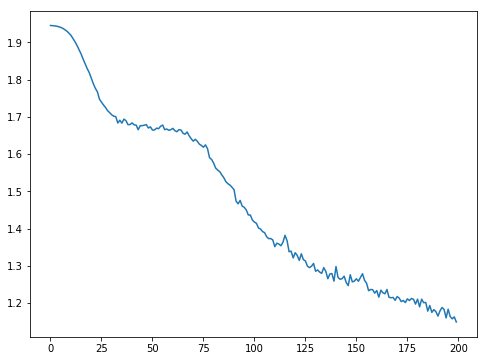

In [247]:
x_input = tf.placeholder(tf.float32, shape=[None, n_features], name='x_input')
y_out = tf.placeholder(tf.int64, shape=[None], name='y_out')

net = network(x_input)
p = tf.nn.softmax(net)

# TensorFlow is not flexible for types. Explicit conversion is necessary each time
correct_pred = tf.equal(tf.argmax(p, 1), y_out)
# reduction operations like mean and sum are done in numpy style
acc = tf.reduce_mean(tf.cast(correct_pred, "float"))

y_out_hot = tf.one_hot(tf.cast(y_out, tf.int64), n_classes)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=net, labels=y_out_hot))
# loss = tf.reduce_mean(-tf.reduce_sum(y_out_hot * tf.log(p), reduction_indices=[1]))
optimizer = tf.train.AdamOptimizer(learning_rate=.00001)
train = optimizer.minimize(loss)

indeces = list(range(X_train.shape[0]))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_loss_epoch = []
    rng_minibatches = range(0, X_train.shape[0] - batch_size + 1, batch_size)
    
    for i in range(0, n_epoch):
        train_loss = 0
        np.random.shuffle(indeces)
        
        for start_idx in rng_minibatches:
            ind = indeces[start_idx:(start_idx + batch_size)]
            X_train_batch = X_train[ind]
            y_train_batch = y_train[ind]
            
            train.run(feed_dict={x_input: X_train_batch, y_out: y_train_batch})

            [loss_value, p_value] = sess.run([loss, p], feed_dict={x_input:X_train_batch, y_out: y_train_batch})
            train_loss += loss_value
    
        test_acc = sess.run(acc, feed_dict={x_input:X_test, y_out: y_test})
        train_acc = sess.run(acc, feed_dict={x_input:X_train, y_out: y_train})
        train_loss = train_loss / len(rng_minibatches)
        
        train_loss_epoch.append(train_loss)
        print('epoch: {}, loss: {:.4f}, train_acc: {:.4f}, test_acc: {:.4f}'.format(i, train_loss, train_acc, test_acc))
        
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_epoch, label='Loss')